In [1]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.patches import Circle
import matplotlib.animation as animation

from utils.plot.utils import plot_cobweb, get_iterative_map_results

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 10 - One-Dimensional Maps

An **iterative map** has the form $x_{n + 1} = f(x_n)$, both the equation (sometimes called a **difference equation**) and the function are often referred to as **maps**. A point $x^*$ such that $f(x^*) = x^*$ is called a fixed point and can be either stable or unstable as with continuous differential equations. Maps can be analysed through **cobweb diagrams**

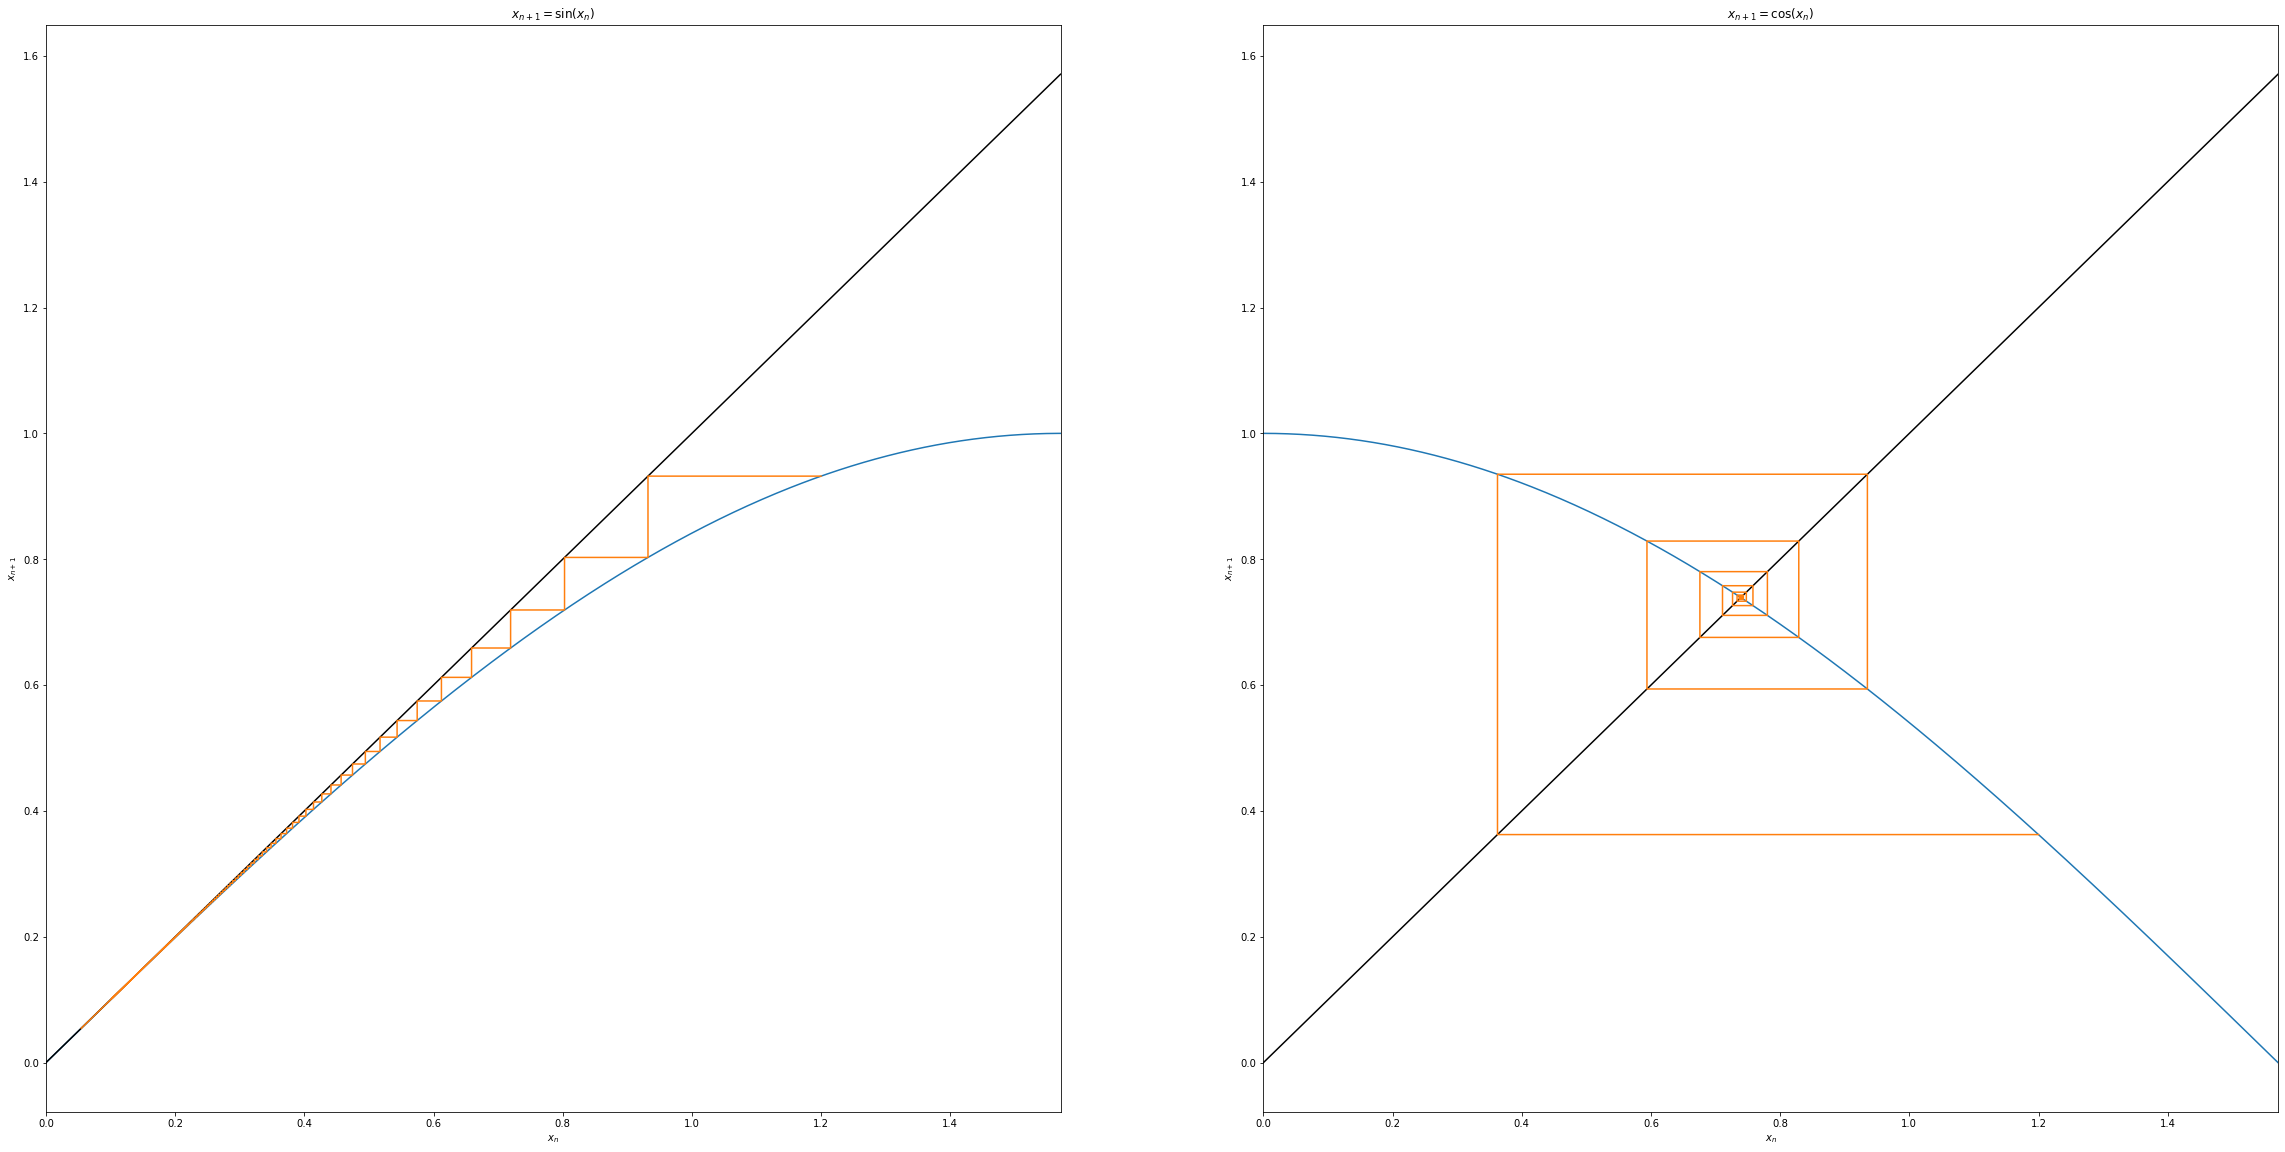

In [2]:
plt.figure(figsize=(40, 20))

plt.subplot(1, 2, 1)
plt.title("$x_{n+1} = \sin(x_n)$")
plt.xlabel("$x_n$")
plt.ylabel("$x_{n + 1}$")
plot_cobweb(lambda x: np.sin(x), [1.2], num_iterations=1000, x_range=[0, np.pi / 2])

plt.subplot(1, 2, 2)
plt.title("$x_{n+1} = \cos(x_n)$")
plt.xlabel("$x_n$")
plt.ylabel("$x_{n + 1}$")
plot_cobweb(lambda x: np.cos(x), [1.2], num_iterations=1000, x_range=[0, np.pi / 2])

## Logistic Map

The logistic map $x_{n + 1} = rx(1-x)$ with $r > 0$ (the discrete analog of the logistic function) displays chaotic behaviour for $3.4 < r < 4$. This can be analysed through an **orbit diagram** which involves plotting the values that the function takes for each value of $r$. For $3 < r < 3.4$ the points bounce back and forth between two points (after they settle down), this is called a **period-2 cycle**, as $r$ increases this then becomes period-4, then period-8..., eventually the period becomes infinite and chaotic motion occurs

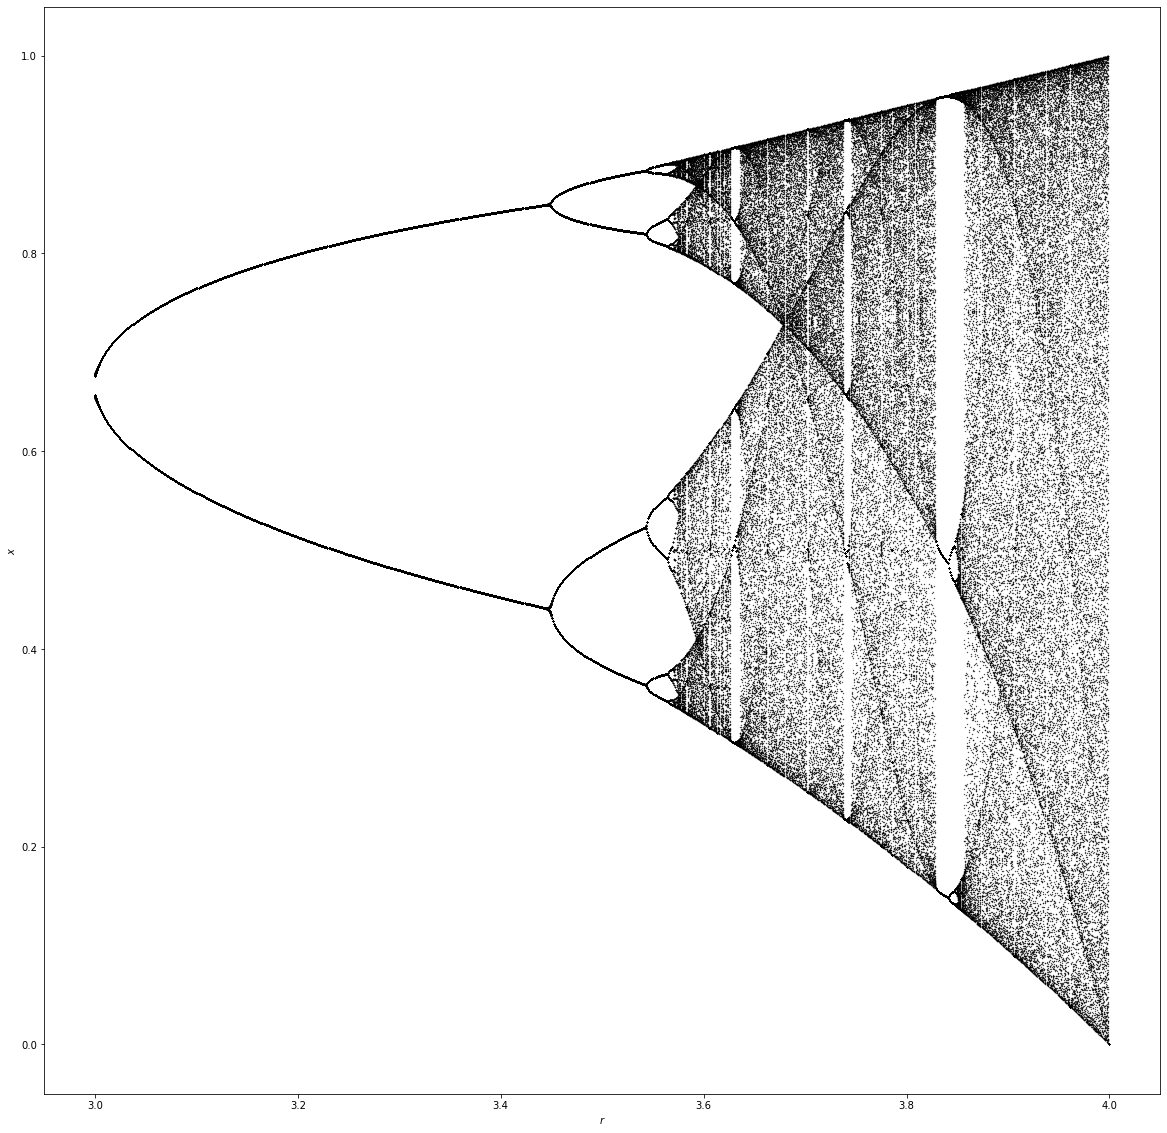

In [3]:
def logistic_map(r):
  return lambda x: r * x * (1 - x)

rs = np.linspace(3, 4, 1000)

for r in rs:
  # Remove the first 300 values to remove transient behaviour from the choice of initial point
  values = get_iterative_map_results(logistic_map(r), .5, 600)[300:]
  plt.scatter([r for _ in values], values, color="black", s=.1)

plt.ylabel("$x$")
plt.xlabel("$r$")
plt.show()

The 3-cycle periodicity at $r \approx 3.8284$ occurs through **intermittant periodicity**: just before this value of $r$ the points spend a lot of time caught near what become stable fixed points for $f^3(x)$ (i.e. stable 3-cycles) but slowly move away, eventually moving far enough away to exhibit chaotic behaviour, the trajectories then eventually come close to an (almost) stable fixed point again and get caught near it (this is also why there are darker lines in the chaotic regions of the orbit diagram). As $r$ approaches the value at which the periodic window occurs, the time spent near the (almost) stable fixed points increase, until eventually they become actual stable fixed points representing 3-cycles. The almost stable fixed points can be viewed as ghosts of the stable 3-cycles (which occur through saddle-node bifurcations)

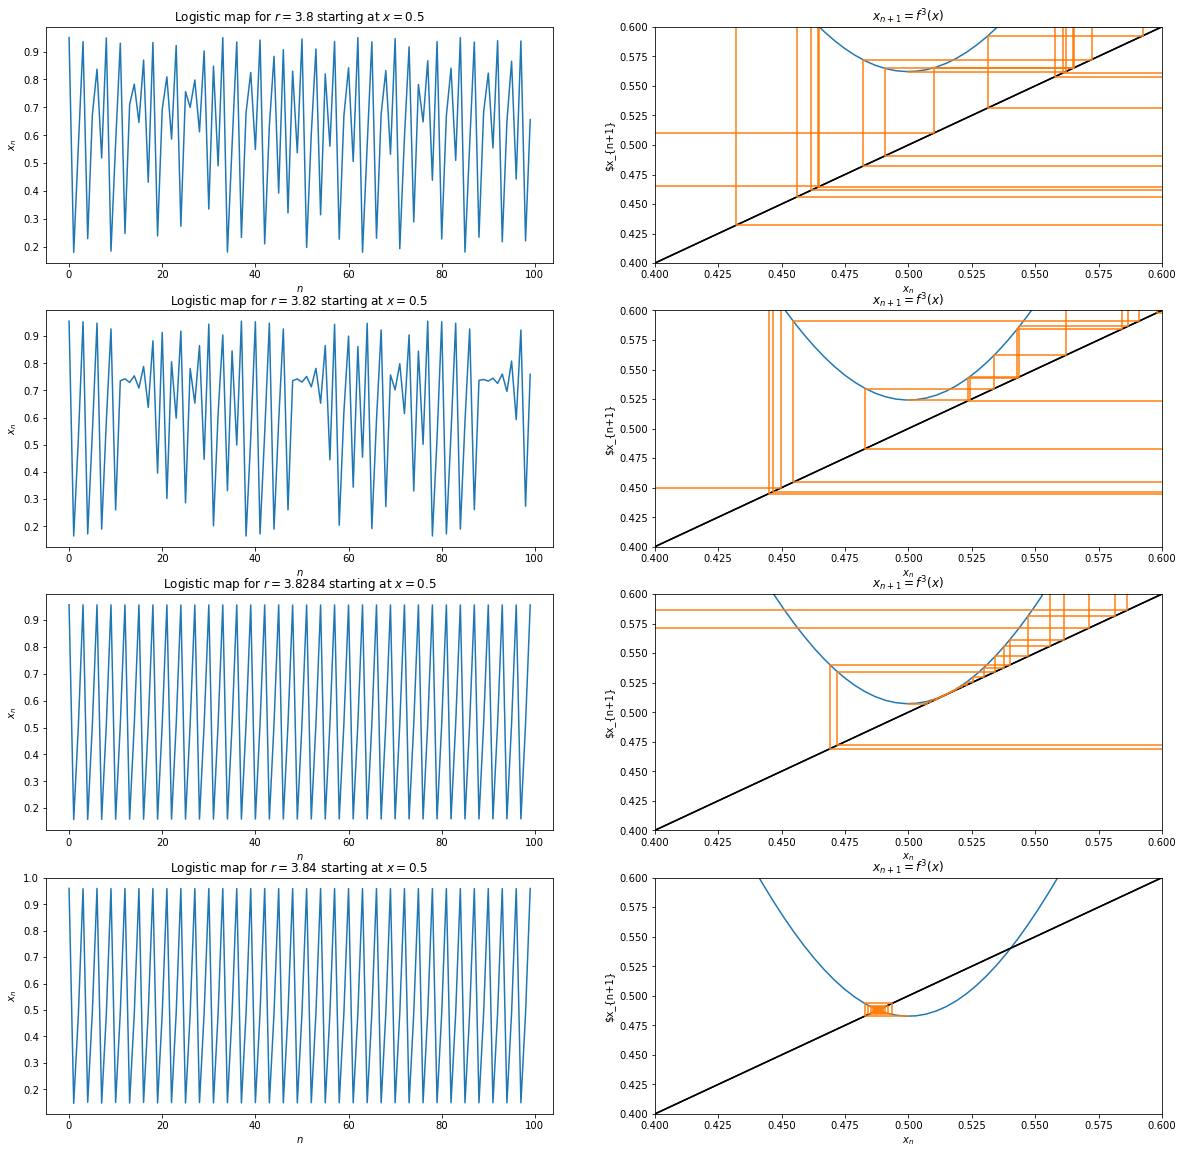

In [68]:
import functools

x = np.linspace(0, 1, 1000)

logistic_map_3 = lambda r: np.vectorize(lambda x: logistic_map)
def logistic_map_3(r):
  map = logistic_map(r)
  return np.vectorize(lambda x: map(map(map(x))))

for idx, r in enumerate([3.8, 3.82, 3.8284, 3.84]):
  plt.subplot(4, 2, idx * 2 + 1)
  x = get_iterative_map_results(logistic_map(r), .5, 100)
  n = [idx for idx, _ in enumerate(x)]
  plt.plot(n, x)
  plt.title(f"Logistic map for $r={r}$ starting at $x=0.5$")
  plt.xlabel("$n$")
  plt.ylabel("$x_n$")

  plt.subplot(4, 2, idx * 2 + 2)
  plt.plot([0, 1], [0, 1], color="black")
  plot_cobweb(logistic_map_3(r), [.5], 100)
  plt.xlim([0.4, .6])
  plt.ylim([0.4, .6])
  plt.title("$x_{n+1} = f^3(x)$")
  plt.ylabel("$x_{n+1}")
  plt.xlabel("$x_n$")